# Including all necessary packages and libraries

In [1]:
from fastai.data.transforms import RandomSplitter
from fastai.vision.augment import aug_transforms
from fastai.vision import *
from fastai.vision.widgets import *

import gradio as gr

from duckduckgo_search import ddg_images
from duckduckgo_search import DDGS
from fastcore.all import *

from fastdownload import download_url
import urllib.request

from pathlib import Path

import requests
from PIL import Image
from io import BytesIO

# This cell consists of the function that gets image from the internet using DuckDuckGo library, which imports images from the internet

In [2]:
def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    ddgs = DDGS()
    results = list(ddgs.images(term))
    return results[:max_images]

# This cell displays the URL thats been searched and provided of the image searched

In [3]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('black person', max_images=1)
urls[0]

Searching for 'black person'


{'title': '"Where are all the black people?" | News | College of the Arts ...',
 'image': 'https://arts.ufl.edu/site/assets/files/143003/lamyportrait.png',
 'thumbnail': 'https://tse2.mm.bing.net/th?id=OIP.tHqZSbzyky-lr4JqwjO2EAHaFW&pid=Api',
 'url': 'https://arts.ufl.edu/in-the-loop/news/where-are-all-the-black-people/',
 'height': 1328,
 'width': 1840,
 'source': 'Bing'}

# This cell downloads and displays the image thats been searched

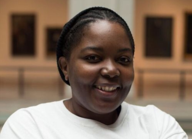

In [4]:
url = urls[0]['image']
dest = 'black-person.jpg'
urllib.request.urlretrieve(url, dest)

im = Image.open(dest)
im.to_thumb(192,192)

# This cell downloads the second image thats been searched for classifying the two images respectively

Searching for 'white person'


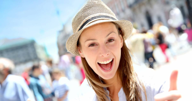

In [5]:
urllib.request.urlretrieve(search_images('white person', max_images=1)[0]['image'], 'white-person.jpg')
Image.open('white-person.jpg').to_thumb(192,192)

# This cell searches for a random image for testing purposes

In [6]:
urllib.request.urlretrieve(search_images('random image', max_images=1)[0]['image'], 'dunno.jpg')
Image.open('dunno.jpg').to_thumb(192,192)

Searching for 'random image'


URLError: <urlopen error [Errno 11001] getaddrinfo failed>

# This cell searches different images with the subject being the same in different scenarios, to train the model better and for better results

In [13]:
from time import sleep

searches = ['white person', 'black person']
path = Path('black_or_not')

for o in searches:
    dest = path/o
    dest.mkdir(exist_ok=True, parents=True)
    
    # Retrieve and save images from different searches
    urls = search_images(f'{o} photo')
    if urls:
        urllib.request.urlretrieve(urls[0]['image'], dest/'photo1.jpg')
    
    sleep(10)  # Pause between searches to avoid over-loading the server
    
    urls = search_images(f'{o} photo in sun')
    if urls:
        urllib.request.urlretrieve(urls[0]['image'], dest/'photo2.jpg')
    
    sleep(10)
    
    urls = search_images(f'{o} photo in shade')
    if urls:
        urllib.request.urlretrieve(urls[0]['image'], dest/'photo3.jpg')
    
    sleep(10)
    
    # Resize images
    image_files = [file for file in dest.ls() if file.suffix.lower() in ['.jpg', '.jpeg', '.png', '.gif']]
    for file in image_files:
        img = Image.open(file)
        resized_img = img.resize((400, 400))  # Set the desired size for resizing
        resized_img.save(file)

Searching for 'white person photo'
Searching for 'white person photo in sun'
Searching for 'white person photo in shade'
Searching for 'black person photo'


HTTPError: HTTP Error 403: Forbidden

# This cell removes the error images that may corrupt the found dataset

In [ ]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

# This block loads the images from the dataset acquired and further classifies it into their categories respectively

In [ ]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

# This cell trains on the photos taken from the internet and calculates the metrics of the model and the dataset its being trained on

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

# This cell checks how well the model will run if its provided with any other input related to the image classication database

In [ ]:
is_black,_,probs = learn.predict(PILImage.create('black-person.jpg'))
print(f"This is a: {is_black}.")
print(f"Probability it's black person: {probs[0]:.4f}")

# This cell exports the trained dataset

In [ ]:
learn.export('racialModel.pkl')

In [ ]:
learn = load_learner('racialModel.pkl')

In [ ]:
download_url(search_images('african male', max_images=1)[0], 'test.jpg', show_progress=False)
Image.open('test.jpg').to_thumb(192,192)

In [ ]:
learn.predict('test.jpg')

In [ ]:
categories = ('Black Person', 'White Person')

def classify_img(img):
    pred,pred_idx,probs = learn.predict(img)
    return dict(zip(categories, map(float,probs)))

In [ ]:
classify_img('test.jpg')

In [ ]:
image = gr.inputs.Image(shape=(192,192))
label = gr.outputs.Label()
examples = ['white-person.jpg','black-person.jpg', 'dunno.jpg']

intf = gr.Interface(fn=classify_img, inputs=image, outputs=label, examples=examples)
intf.launch(inline=False)